In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk import ngrams
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from sklearn.utils import resample 
# Importar triu desde numpy
triu = np.triu
import re


In [2]:
#NLTK
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/leire/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/leire/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/leire/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/leire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Cargar modelo de spaCy para NER
nlp = spacy.load("en_core_web_sm")



In [4]:
# Cargar el archivo CSV
data = pd.read_csv("comentarios.csv")

In [5]:
print("Dimensiones del conjunto de datos:", data.shape)
print("Primeras filas de los datos:")
print(data.head())
display(data.head())

Dimensiones del conjunto de datos: (1000, 15)
Primeras filas de los datos:
              CommentId      VideoId  \
0  Ugg2KwwX0V8-aXgCoAEC  04kJtp6pVXI   
1  Ugg2s5AzSPioEXgCoAEC  04kJtp6pVXI   
2  Ugg3dWTOxryFfHgCoAEC  04kJtp6pVXI   
3  Ugg7Gd006w1MPngCoAEC  04kJtp6pVXI   
4  Ugg8FfTbbNF8IngCoAEC  04kJtp6pVXI   

                                                Text  IsToxic  IsAbusive  \
0  If only people would just take a step back and...    False      False   
1  Law enforcement is not trained to shoot to app...     True       True   
2  \nDont you reckon them 'black lives matter' ba...     True       True   
3  There are a very large number of people who do...    False      False   
4  The Arab dude is absolutely right, he should h...    False      False   

   IsThreat  IsProvocative  IsObscene  IsHatespeech  IsRacist  IsNationalist  \
0     False          False      False         False     False          False   
1     False          False      False         False     False      

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


#valores faltantes

In [6]:
"""
missing_values = data.isnull().sum()
print("Valores faltantes por columna:\n", missing_values[missing_values > 0])

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Mapa de Valores Faltantes")
plt.savefig("valores_faltantes.png")
plt.show()
"""


'\nmissing_values = data.isnull().sum()\nprint("Valores faltantes por columna:\n", missing_values[missing_values > 0])\n\nplt.figure(figsize=(10, 6))\nsns.heatmap(data.isnull(), cbar=False, cmap=\'viridis\')\nplt.title("Mapa de Valores Faltantes")\nplt.savefig("valores_faltantes.png")\nplt.show()\n'

#limpieza de texto

In [7]:
def clean_text_advanced(text):
    # Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Eliminar menciones y hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Eliminar caracteres especiales y números, convertir a minúsculas
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text.lower()

data['cleaned_text'] = data['Text'].apply(clean_text_advanced)

#tokenizar y lematizar

In [8]:
def tokenize_and_lemmatize(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

data['tokenized_text'] = data['cleaned_text'].apply(tokenize_and_lemmatize)

#Outliers en longitud comentarios


count    1000.000000
mean      185.554000
std       270.780777
min         3.000000
25%        47.000000
50%       101.000000
75%       217.000000
max      4421.000000
Name: text_length, dtype: float64


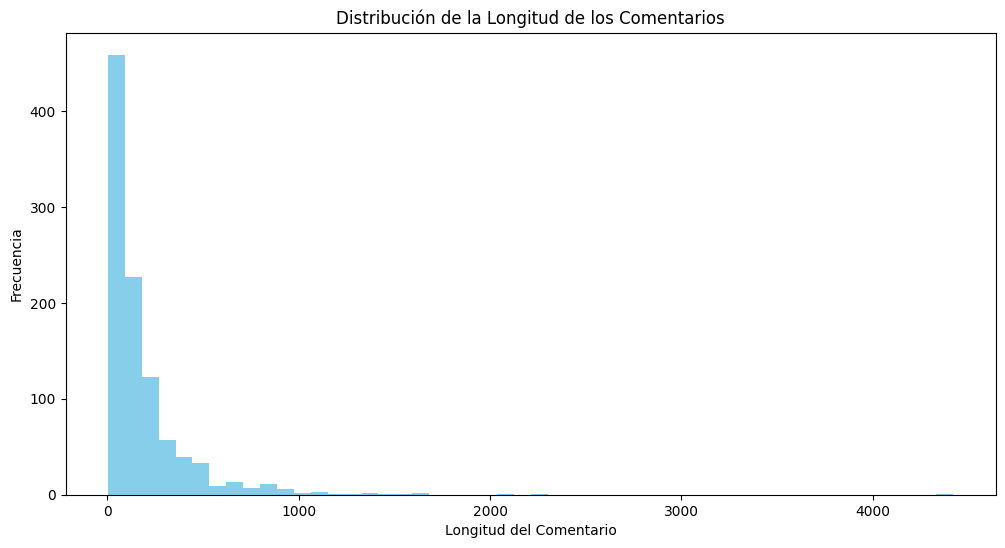

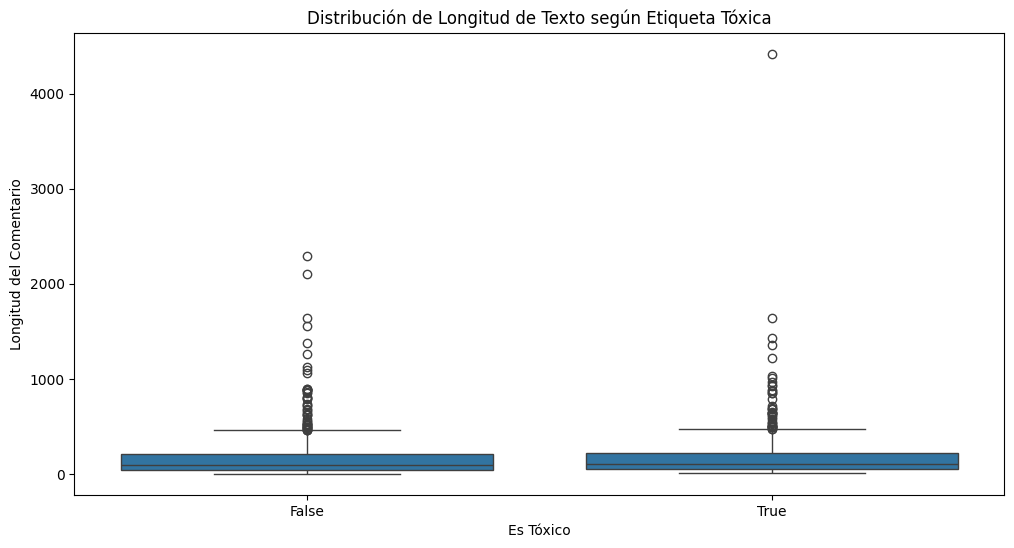

In [9]:
# Crear una columna de longitud de texto
data['text_length'] = data['Text'].apply(len)
print(data['text_length'].describe())

# Histograma de la longitud de los comentarios
plt.figure(figsize=(12, 6))
plt.hist(data['text_length'], bins=50, color='skyblue')
plt.title("Distribución de la Longitud de los Comentarios")
plt.xlabel("Longitud del Comentario")
plt.ylabel("Frecuencia")
plt.savefig("longitud_comentarios.png")
plt.show()

# Caja de bigotes para detectar outliers en la longitud de comentarios
plt.figure(figsize=(12, 6))
sns.boxplot(x='IsToxic', y='text_length', data=data)
plt.title("Distribución de Longitud de Texto según Etiqueta Tóxica")
plt.xlabel("Es Tóxico")
plt.ylabel("Longitud del Comentario")
plt.savefig("outliers_longitud.png")
plt.show()

#Etiquetas de toxicidad

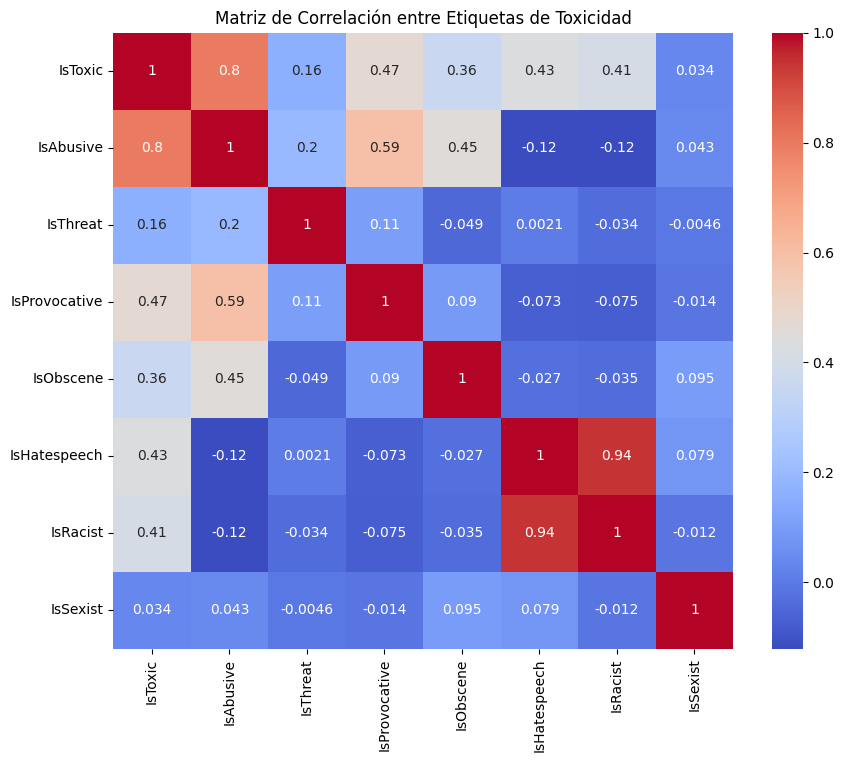

In [10]:
toxic_labels = ['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsSexist']


# matriz de correlación
correlation_matrix = data[['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsSexist']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación entre Etiquetas de Toxicidad")
plt.savefig("matriz_correlacion.png")
plt.show()

#balanceo de clases (sobremuestreo)

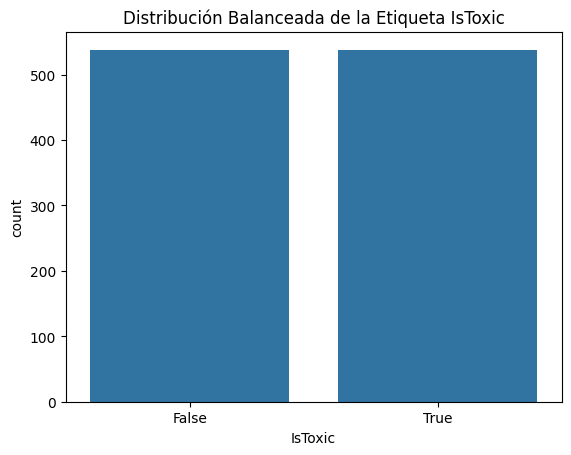

In [11]:



toxic_data = data[data['IsToxic'] == True]
non_toxic_data = data[data['IsToxic'] == False]
toxic_upsampled = resample(toxic_data, replace=True, n_samples=len(non_toxic_data), random_state=42)
data_balanced = pd.concat([toxic_upsampled, non_toxic_data]).sample(frac=1).reset_index(drop=True)

sns.countplot(x='IsToxic', data=data_balanced)
plt.title("Distribución Balanceada de la Etiqueta IsToxic")
plt.savefig("distribucion_balanceada.png")
plt.show()



#n-gramas

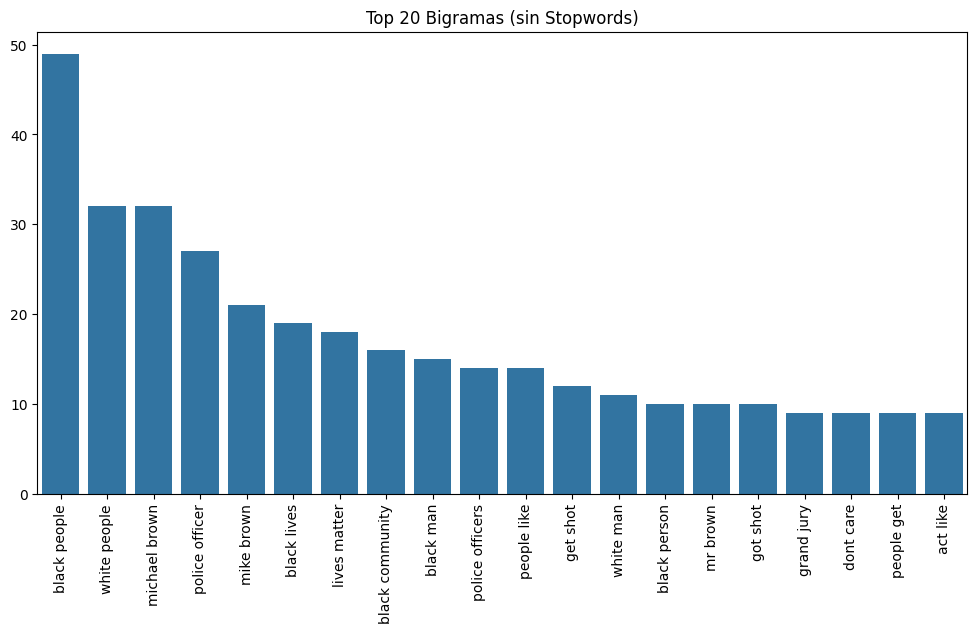

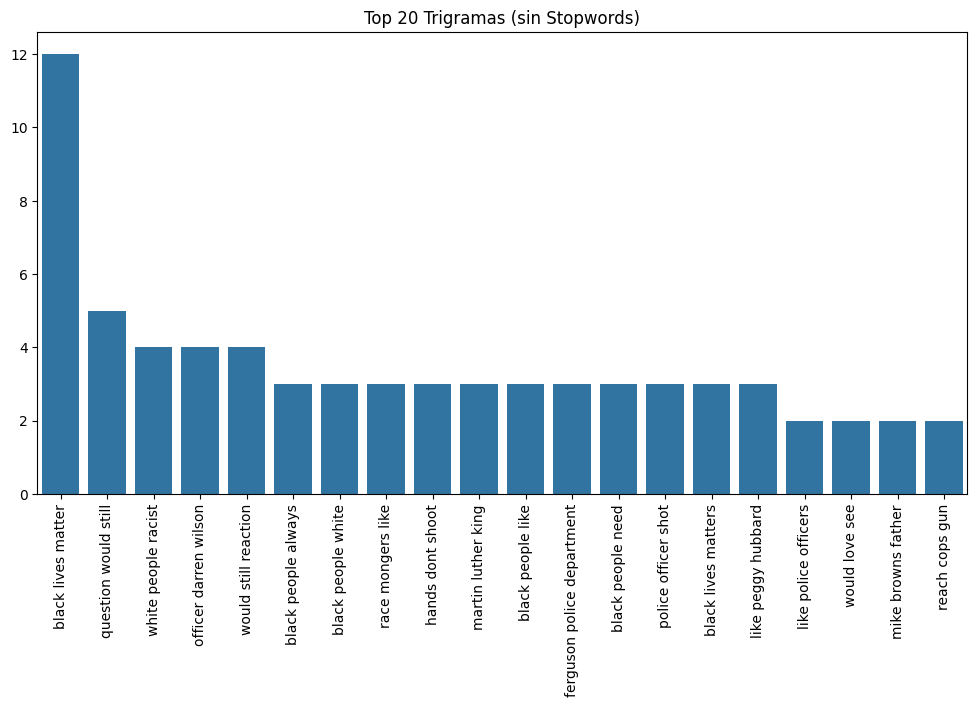

In [12]:
stop_words = set(stopwords.words('english'))

def get_top_ngrams_filtered(corpus, n, top_k):
    words = [word for word in corpus.split() if word not in stop_words]
    ngrams_list = list(ngrams(words, n))
    return Counter(ngrams_list).most_common(top_k)

#bigramas
top_bigrams_filtered = get_top_ngrams_filtered(' '.join(data['cleaned_text']), 2, 20)
plt.figure(figsize=(12, 6))
sns.barplot(x=[' '.join(ng[0]) for ng in top_bigrams_filtered], y=[ng[1] for ng in top_bigrams_filtered])
plt.title("Top 20 Bigramas (sin Stopwords)")
plt.xticks(rotation=90)
plt.savefig("top_bigramas.png")
plt.show()

#trigramas
top_trigrams_filtered = get_top_ngrams_filtered(' '.join(data['cleaned_text']), 3, 20)

plt.figure(figsize=(12, 6))
sns.barplot(x=[' '.join(ng[0]) for ng in top_trigrams_filtered], y=[ng[1] for ng in top_trigrams_filtered])
plt.title("Top 20 Trigramas (sin Stopwords)")
plt.xticks(rotation=90)
plt.savefig("top_trigramas.png")
plt.show()

#normalización lingüistica

In [13]:
scaler = StandardScaler()
data['normalized_word_count'] = scaler.fit_transform(data[['text_length']])
data['normalized_lexical_diversity'] = scaler.fit_transform(data[['text_length']])


#Wor2vec

In [14]:
w2v_model = Word2Vec(sentences=data['tokenized_text'], vector_size=100, window=5, min_count=2)

def get_mean_vector(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

data['mean_vector'] = data['tokenized_text'].apply(get_mean_vector)


#Análisis de sentimientos


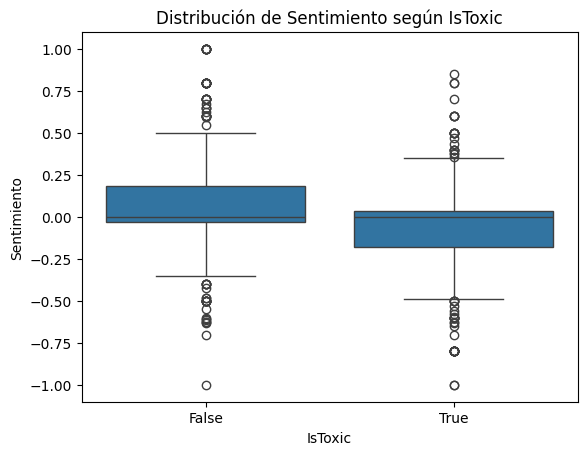

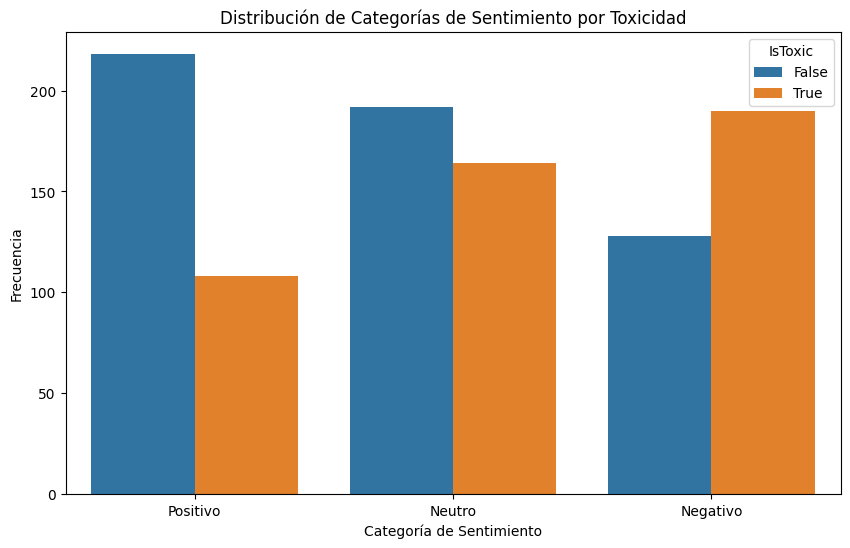

In [15]:
data['sentiment'] = data['cleaned_text'].apply(lambda text: TextBlob(text).sentiment.polarity)
sns.boxplot(x='IsToxic', y='sentiment', data=data)
plt.title("Distribución de Sentimiento según IsToxic")
plt.xlabel("IsToxic")
plt.ylabel("Sentimiento")
plt.savefig("distribucion_sentimiento.png")
plt.show()


# Análisis de sentimientos más detallado
def categorize_sentiment(polarity):
    if polarity > 0.05:
        return 'Positivo'
    elif polarity < -0.05:
        return 'Negativo'
    else:
        return 'Neutro'

data['sentiment_category'] = data['sentiment'].apply(categorize_sentiment)

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_category', hue='IsToxic', data=data)
plt.title("Distribución de Categorías de Sentimiento por Toxicidad")
plt.xlabel("Categoría de Sentimiento")
plt.ylabel("Frecuencia")
plt.savefig("distribucion_categoria_sentimiento.png")
plt.show()




#NER

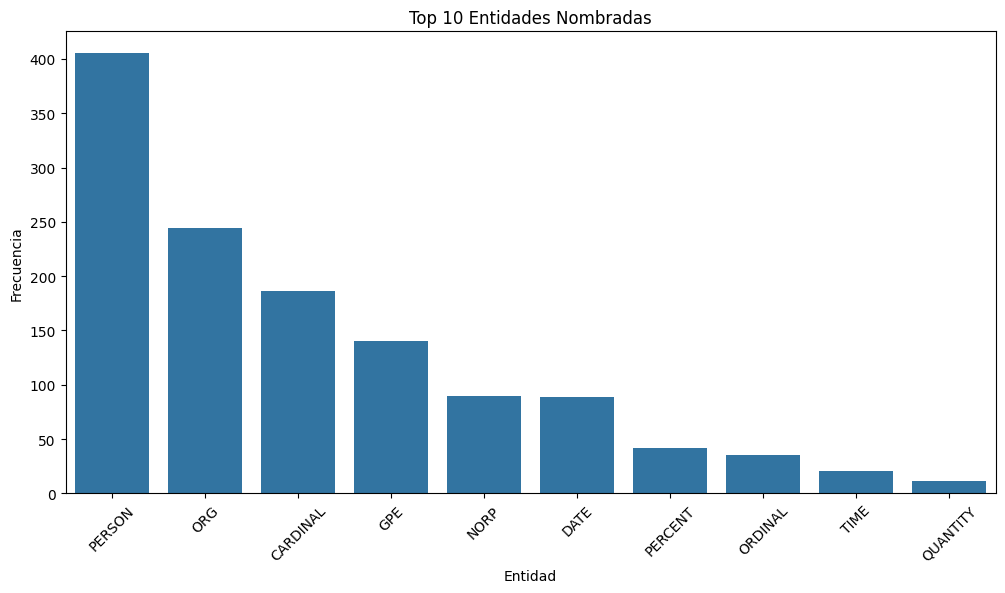

In [16]:
def extract_entities(text):
    doc = nlp(text)
    return [ent.label_ for ent in doc.ents]

data['entities'] = data['Text'].apply(extract_entities)

entity_counts = Counter([entity for entities in data['entities'] for entity in entities])
top_entities = entity_counts.most_common(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=[entity[0] for entity in top_entities], y=[entity[1] for entity in top_entities])
plt.title("Top 10 Entidades Nombradas")
plt.xlabel("Entidad")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.savefig("top_entidades.png")
plt.show()


#nube de palabras

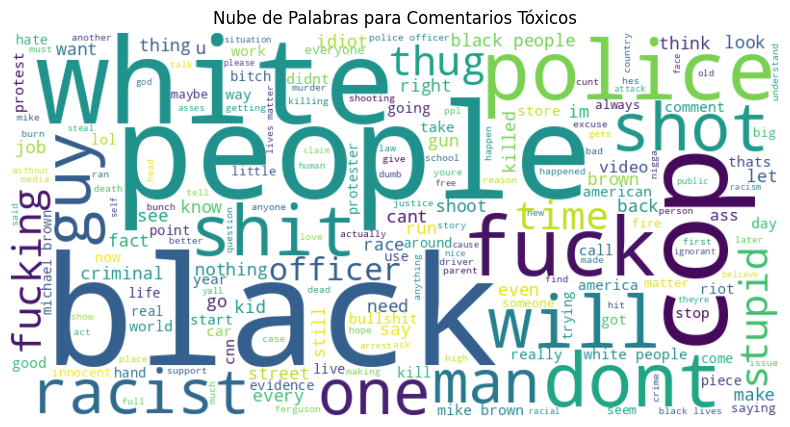

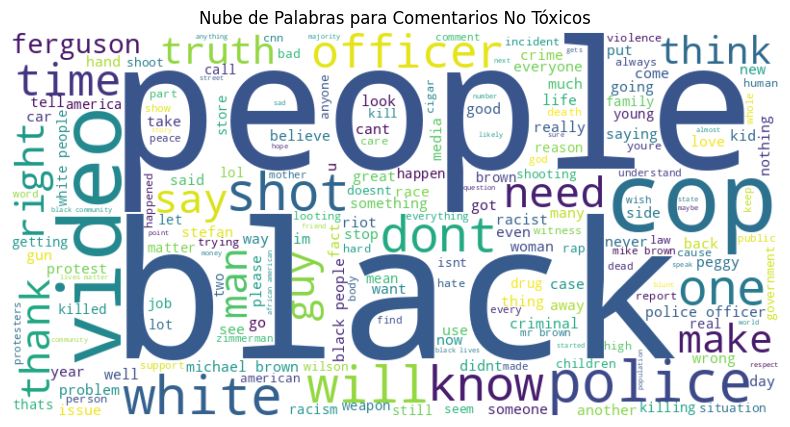

In [17]:
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

toxic_comments = data[data['IsToxic'] == True]['cleaned_text']
non_toxic_comments = data[data['IsToxic'] == False]['cleaned_text']

plot_word_cloud(toxic_comments, "Nube de Palabras para Comentarios Tóxicos")
plot_word_cloud(non_toxic_comments, "Nube de Palabras para Comentarios No Tóxicos")

Exportación


In [18]:
data.to_csv('comentarios_limpios.csv', index=False)
print("\nDatos procesados guardados en 'comentarios_procesados.csv'")


Datos procesados guardados en 'comentarios_procesados.csv'
